In [294]:
import numpy as np
import pandas as pd
import os
from contrastive.augmentations import PartialCutOutTensor_Roll
import torch
import matplotlib.pyplot as plt

In [295]:
sulcus = 'F.I.P.'
side = 'R'
patch_size=[10,20]
from_skeleton=True

mask = np.load(f'/volatile2/jl277509/data/UkBioBank40/crops/2mm/{sulcus}/{side}mask.npy')
input = torch.tensor(mask.astype(np.float32))
# norm mask
mask = mask / np.sum(mask)
input_size = [1]+list(mask.shape[:-1])
nb_iter=1000

In [296]:
output_list=[]
for i in range(nb_iter):
    cutout = PartialCutOutTensor_Roll(sample_foldlabel=input,
                                  mask=mask,
                                  mask_constraint=True,
                                  from_skeleton=from_skeleton,
                                  input_size=input_size,
                                  keep_extremity='bottom',
                                  keep_proba_per_branch=0.,
                                  keep_proba_global=0.,
                                  patch_size=patch_size,
                                  random_size=False,
                                  localization=None)
    output = cutout(input)
    output_list.append(output)

In [297]:
outputs = np.stack(output_list)

In [298]:
cutout_map=np.sum(outputs, axis=0)
cutout_map = nb_iter - cutout_map
cutout_map = cutout_map.flatten()
cutout_map = cutout_map[cutout_map!=nb_iter]
cutout_map = cutout_map / nb_iter

In [299]:
cutout_map

array([0.129, 0.14 , 0.138, ..., 0.129, 0.131, 0.127], dtype=float32)

Text(0.5, 1.0, 'Mean = 0.146 Deviation = 0.014')

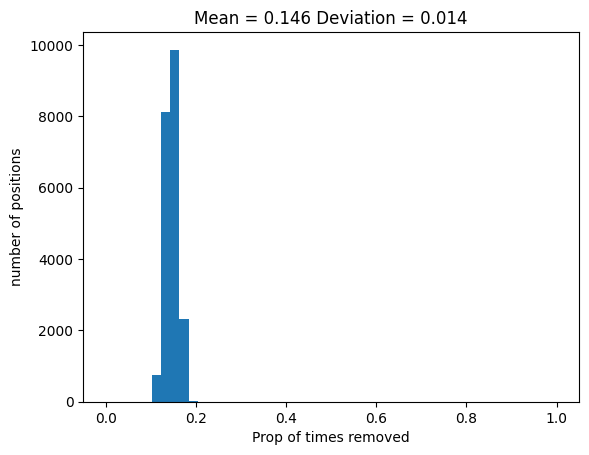

In [300]:
plt.hist(cutout_map, bins=np.linspace(0,1,50))
plt.ylabel('number of positions')
plt.xlabel('Prop of times removed')
plt.title(f'Mean = {np.mean(cutout_map):.3f} Deviation = {np.std(cutout_map):.3f}')

In [282]:
## what prop for center point ?
dims = mask.shape
center = dims[0] // 2, dims[1] // 2, dims[2] // 3, 0
prop_center = (nb_iter - np.sum(outputs, axis=0)[center]) / nb_iter
## maximized ...
print(prop_center, max(cutout_map), min(cutout_map))

0.442 0.455 0.075


In [283]:
## let's change the probability pixel wise to select center
mask_ = nb_iter - np.sum(outputs, axis=0)
mask_ = 1 / np.power(mask_,2) # invert the proba ## BUT HOW ? 
mask_[mask==0]=0
tot = np.sum(mask_)
mask_ = mask_ / tot

In [284]:
np.mean(mask_), np.max(mask_)

(np.float32(1.2950015e-05), np.float32(0.00043075488))

In [285]:
output_list=[]
for i in range(nb_iter):
    cutout = PartialCutOutTensor_Roll(sample_foldlabel=input,
                                  mask=mask_, ## corrected mask with proba
                                  mask_constraint=True,
                                  from_skeleton=from_skeleton,
                                  input_size=input_size,
                                  keep_extremity='bottom',
                                  keep_proba_per_branch=0.,
                                  keep_proba_global=0.,
                                  patch_size=patch_size,
                                  random_size=False,
                                  localization=None)
    output = cutout(input)
    output_list.append(output)

In [286]:
outputs = np.stack(output_list)

In [287]:
cutout_map=np.sum(outputs, axis=0)
cutout_map = nb_iter - cutout_map
cutout_map = cutout_map.flatten()
cutout_map = cutout_map[cutout_map!=nb_iter]
cutout_map = cutout_map / nb_iter

Text(0.5, 1.0, 'Mean = 0.216 Deviation = 0.043')

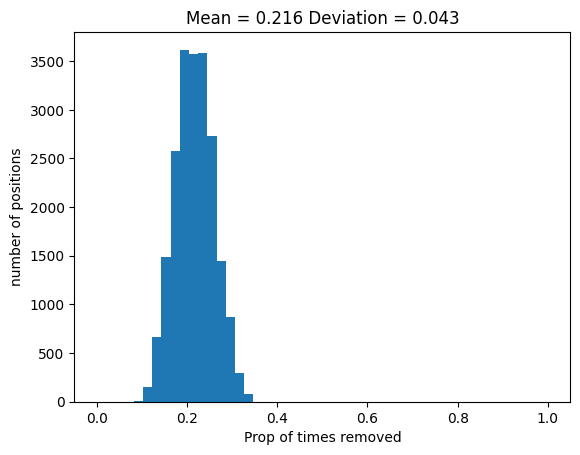

In [288]:
plt.hist(cutout_map, bins=np.linspace(0,1,50))
plt.ylabel('number of positions')
plt.xlabel('Prop of times removed')
plt.title(f'Mean = {np.mean(cutout_map):.3f} Deviation = {np.std(cutout_map):.3f}')

In [289]:
## what prop for center point ?
dims = mask.shape
center_x, center_y, center_z = dims[0] // 2, dims[1] // 2, dims[2] // 2
prop_center = np.mean((nb_iter - np.sum(outputs, axis=0)[center_x-1:center_x+2, center_y-1:center_y+2, center_z-1:center_z+2]) / nb_iter)
## maximized ...
print(prop_center, max(cutout_map), min(cutout_map))

0.23262964 0.34 0.09


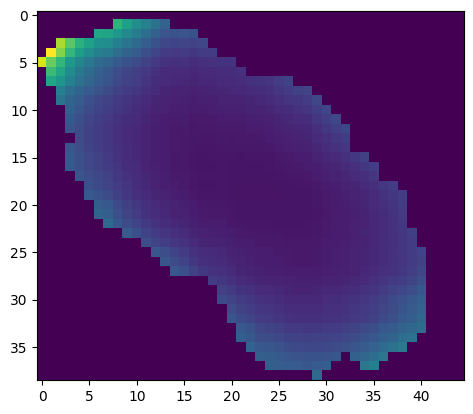

In [290]:
plt.imshow(mask_[:,:,20,0])

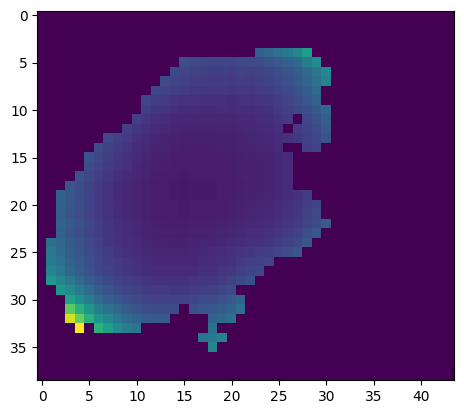

In [291]:
plt.imshow(mask_[:,20,:,0])

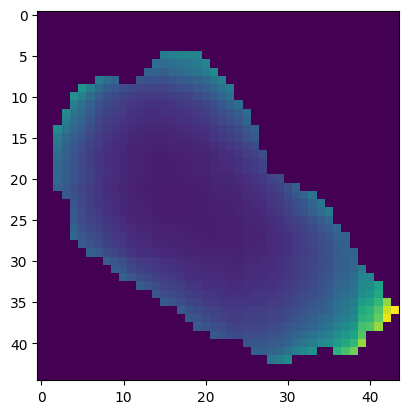

In [292]:
plt.imshow(mask_[20,:,:,0])

In [293]:
## save proba_mask
np.save(f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/crops/2mm/{sulcus}/mask/{side}mask_proba.npy', mask_)

In [273]:
mask_.shape

(39, 45, 44, 1)